In [3]:
1.0579*1.0814-0.1092

1.03481306

In [ ]:
import optimize
import optfolio
import nsga2
import objectives
import report
import returns_projection
import utils

ModuleNotFoundError: ignored

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
from datetime import timedelta, datetime

import numpy as np
import yfinance as yf



In [ ]:
#HGLG11 e 22% em SDIL11
fi_data = yf.download('HGLG11.SA SDIL11.SA', start="2020-03-18", end="2023-02-28")
data=fi_data['Adj Close']


[*********************100%***********************]  2 of 2 completed


In [ ]:
daily_returns = (data/ data.shift(1) - 1)[1:]
daily_returns.head()

,HGLG11.SA,SDIL11.SA
Date,,
2020-03-19,0.107304,0.008686
2020-03-20,0.049302,0.090278
2020-03-23,-0.019191,-0.095542
2020-03-24,0.049554,0.070423
2020-03-25,0.089357,0.111842


In [ ]:
bv_data = yf.download('BOVA11.SA', start="2020-03-18", end="2023-02-28")
bv_data=bv_data['Adj Close']

bv_daily_returns = (bv_data/ bv_data.shift(1) - 1)[1:]
bv_daily_returns.head()

[*********************100%***********************]  1 of 1 completed


Date
2020-03-19   -0.000154
2020-03-20   -0.003539
2020-03-23   -0.056044
2020-03-24    0.102388
2020-03-25    0.064243
Name: Adj Close, dtype: float64

In [ ]:
#CARE11
bv_data2 = yf.download('CARE11.SA', start="2020-03-18", end="2023-02-28")
bv_data2=bv_data2['Adj Close']

bv_daily_returns2 = (bv_data2/ bv_data2.shift(1) - 1)[1:]
bv_daily_returns2.head()

[*********************100%***********************]  1 of 1 completed


Date
2020-03-19    0.070423
2020-03-20    0.052632
2020-03-23   -0.025000
2020-03-24    0.012821
2020-03-25    0.126582
Name: Adj Close, dtype: float64

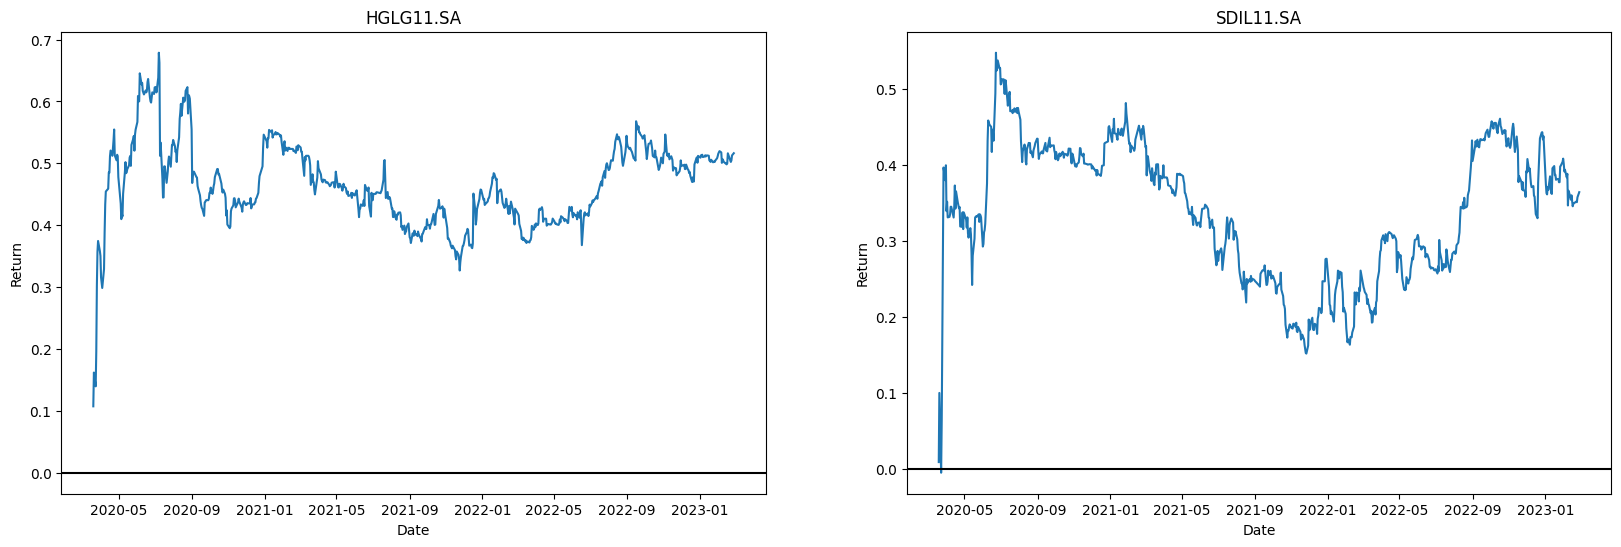

In [ ]:
#ações
n_rows = int(np.ceil(daily_returns.shape[1] / 2.0))
plt.figure(figsize=(20, n_rows * 6))
for i, ticker in enumerate(daily_returns.columns):
    plt.subplot(n_rows, 2, i + 1)
    plt.title(ticker)
    plt.plot(np.cumprod(daily_returns[ticker] + 1) - 1)
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.axhline(0, color='black')
plt.show()

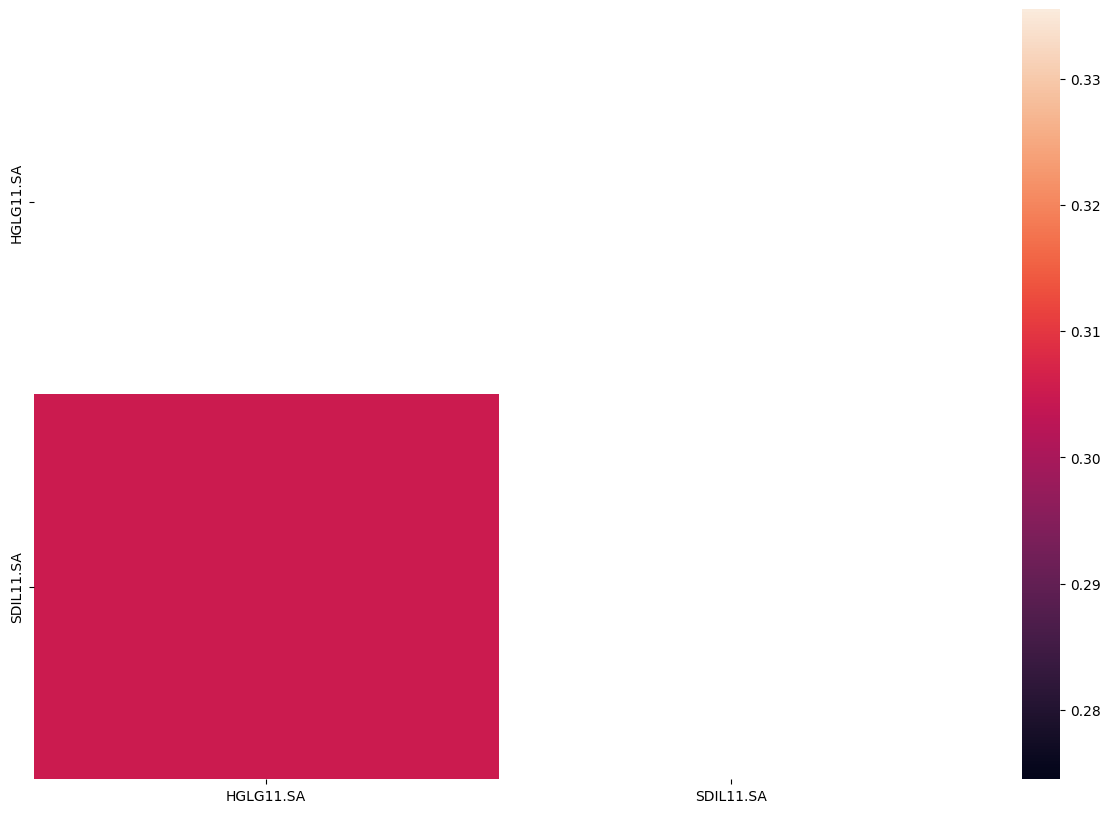

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,10))
cm = daily_returns.corr()
mask = (1 - np.tril(np.ones_like(cm))) == 1
cm[np.eye(cm.shape[0]) == 1] = np.nan
cm[mask] = np.nan
# cm[cm <= 0.5] = np.nan
sns.heatmap(cm)
plt.show()

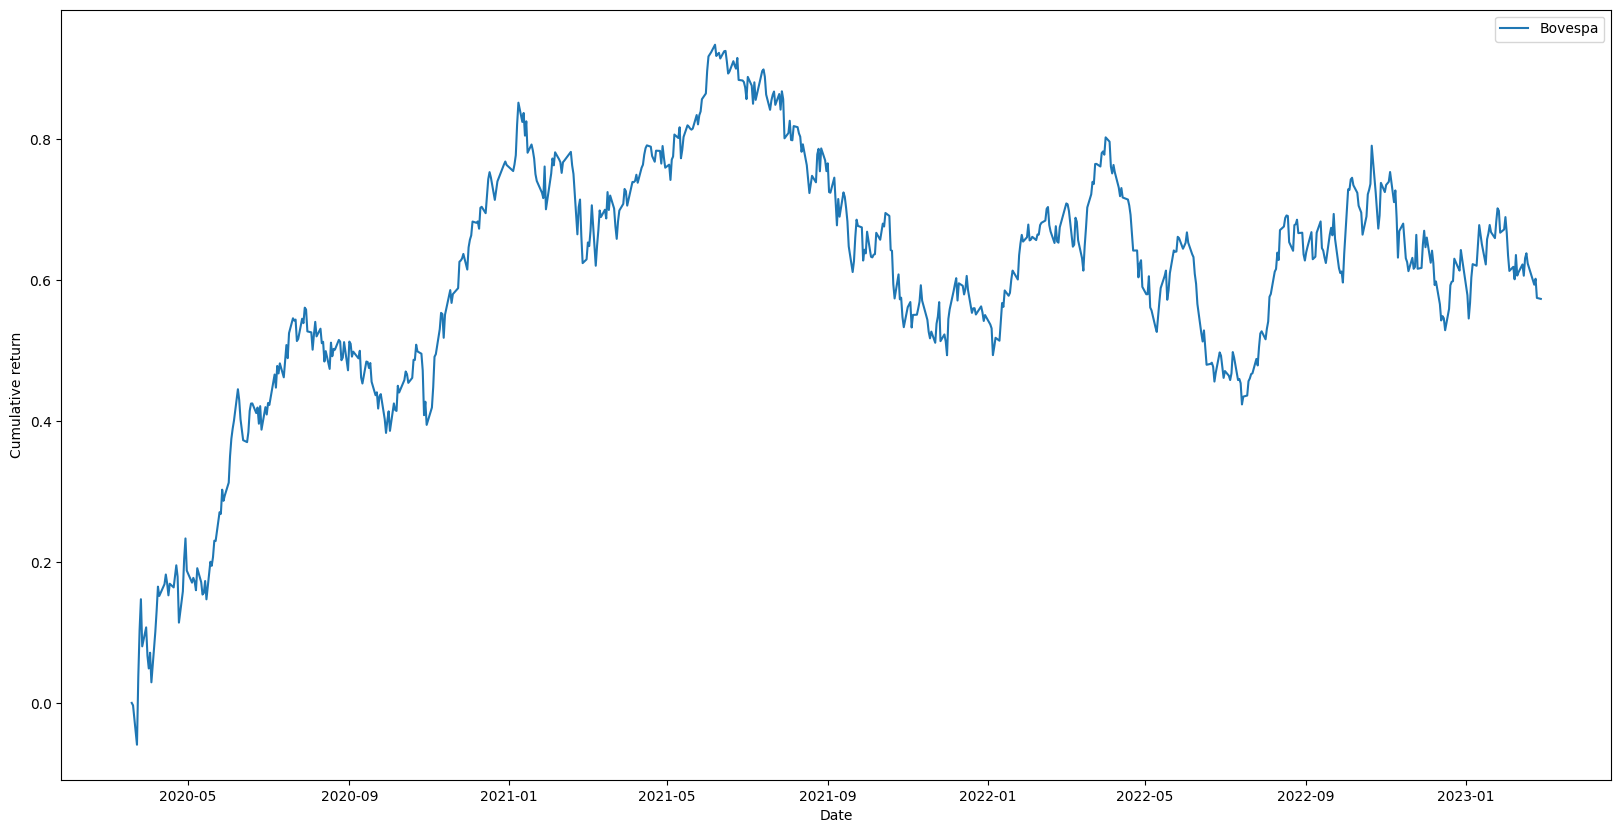

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.cumprod(bv_daily_returns + 1) - 1, label='Bovespa')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

In [ ]:
YEAR_BARS = 252
TEST_YEARS = 0
TRAIN_END_DATE = data.index.max() - timedelta(days=TEST_YEARS * 365)
train = daily_returns[(daily_returns.index < TRAIN_END_DATE)].fillna(0)
test = daily_returns[(daily_returns.index >= TRAIN_END_DATE)].fillna(0)

bv_train = bv_daily_returns[(bv_daily_returns.index < TRAIN_END_DATE)].fillna(0)
bv_test = bv_daily_returns[(bv_daily_returns.index >= TRAIN_END_DATE)].fillna(0)

print(np.any(np.isnan(train)))
print(train.shape)
train.tail()

False
(730, 2)


,HGLG11.SA,SDIL11.SA
Date,,
2023-02-16,0.001002,-0.005681
2023-02-17,0.010944,0.002400
2023-02-22,-0.009217,0.002280
2023-02-23,0.001623,-0.000682
2023-02-24,0.005361,0.004780


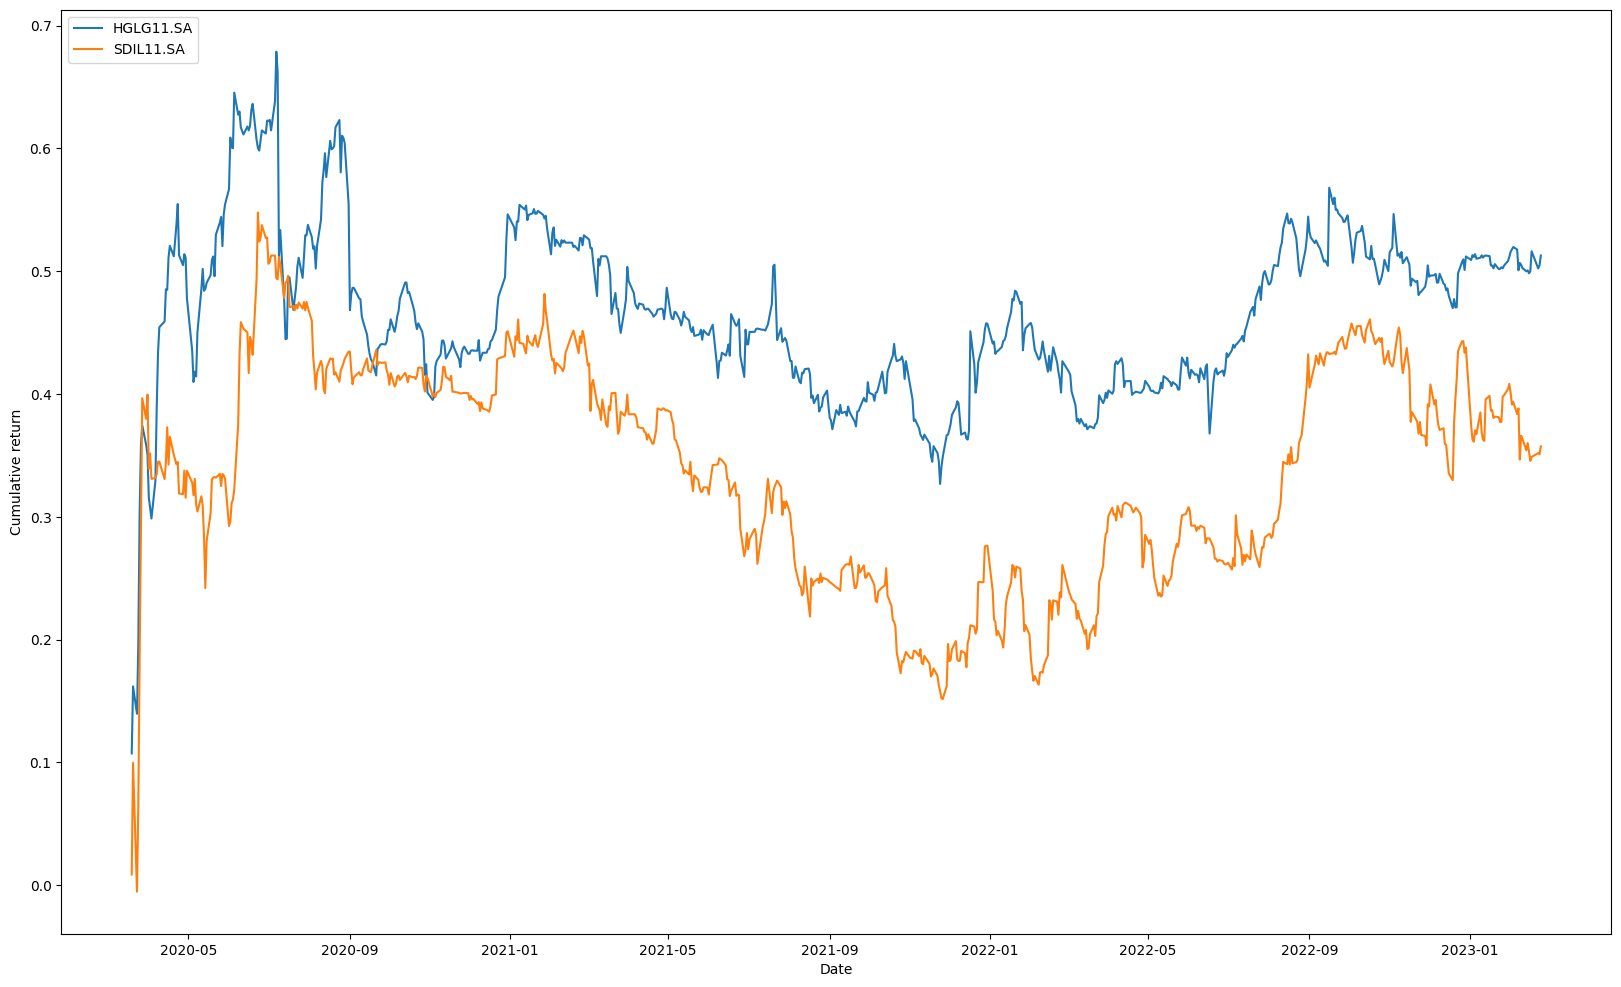

In [ ]:
plt.figure(figsize=(20,12))
for col in train.columns:
    plt.plot(np.cumprod(train[col] + 1) - 1, label=col)

plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend(loc='upper left')
plt.show()

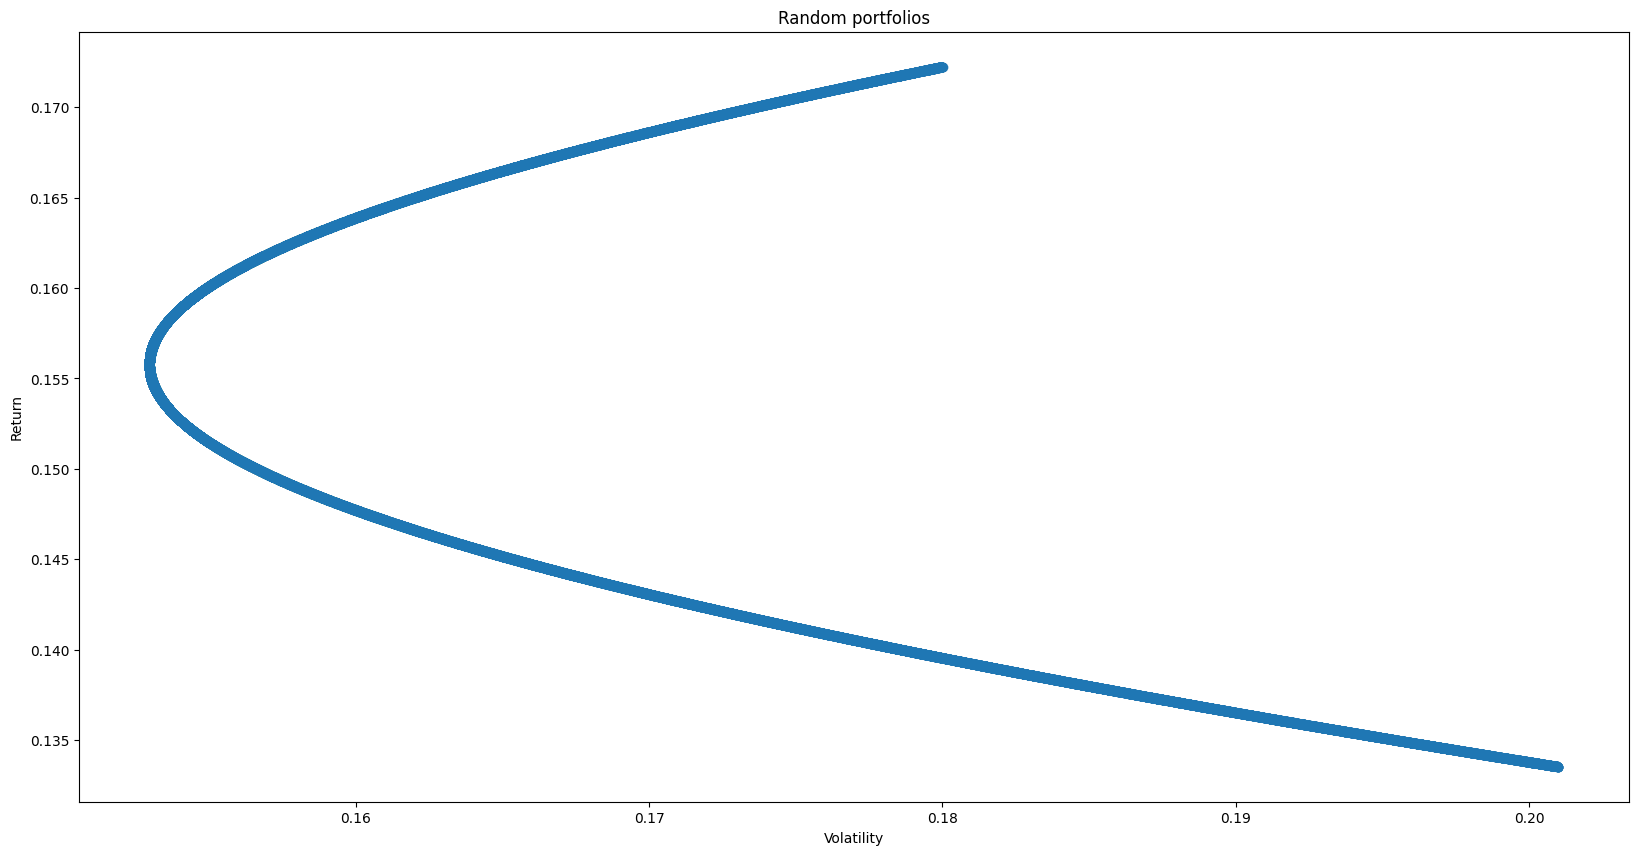

In [ ]:
def random_population(n_assets, population_size):
    weights = np.random.uniform(0, 1, size=(population_size, n_assets))

    return weights / weights.sum(axis=-1).reshape((-1, 1))

def annualized_portfolio_return(returns, weights):
    weighted_returns = np.matmul(weights, np.mean(returns.values, 0))

    return (weighted_returns + 1) ** YEAR_BARS - 1


def annualized_portfolio_volatility(returns, weights):
    variance = np.sum(weights * np.matmul(weights, np.cov(returns.T.values)), -1)

    return np.sqrt(variance) * np.sqrt(YEAR_BARS)


def annualized_portfolio_performance(returns, weights):
    return np.stack([
        annualized_portfolio_return(returns, weights),
        annualized_portfolio_volatility(returns, weights)
    ], -1)

rand_weights = random_population(train.shape[1], 100000)
rand_solutions = annualized_portfolio_performance(train, rand_weights)

plt.figure(figsize=(20,10))
plt.title('Random portfolios')
plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [ ]:
import sys
sys.path.insert(0,'/content/')

In [ ]:
optimizer = optimize.Optimizer(mutation_sigma=1.0, verbose=False, max_iter=250, population_size=5000)
solutions, stats = optimizer.run(train.values)

NameError: ignored

In [ ]:
solutions.shape

In [ ]:
def plot_solutions(data, solutions, rand_solutions):
    ov = annualized_portfolio_performance(data, solutions)
    plt.figure(figsize=(20,10))
    plt.title('Solutions')
    plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
    plt.scatter(ov[:,1], ov[:,0], alpha=.5)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()

plot_solutions(train, solutions, rand_solutions)

In [ ]:
ov = annualized_portfolio_performance(train, solutions)
sharpe = ov[:,0] / ov[:,1]
solution = solutions[np.argmax(ov[:,0] / ov[:,1])]
# solution = solutions[np.argmin(np.abs(ov[:,1] - 0.16))]
annualized_portfolio_performance(train, solution)

In [ ]:
CAPITAL = 1000

def print_allocation(data, allocations, prices):
    for ticker_id in np.argsort(-allocations):
        print('%s - %.4f, $%.2f USD, %.2f shares' % (data.columns[ticker_id], allocations[ticker_id] * 100, CAPITAL * allocations[ticker_id], (CAPITAL * allocations[ticker_id]) / prices[data.columns[ticker_id]]))

print_allocation(train, solution, data.iloc[-1])

In [ ]:
','.join(train.columns)

In [ ]:
ret = np.dot(train, solution)
plt.hist(ret, bins=1000)
plt.show()

In [ ]:
from returns_projection import cumulative_n_period_returns, sample_returns, mcmc_sample_returns
from report import plot_traces, returns_table

### Bovespa

In [ ]:
bv_train

In [ ]:
print("Annualized return: %.6f" % (np.mean(bv_train + 1) ** 252 - 1))
print("Annualized volatility: %.6f" % (np.sqrt(np.var(bv_train) * 252)))

In [ ]:
bv_traces = sample_returns(bv_train, 10 * 252, n_traces=100000)

In [ ]:
bv_cum_returns = plot_traces(bv_traces)
returns_table(bv_cum_returns)

### MC Projection

In [ ]:
traces = sample_returns(ret, 10 * 252, n_traces = 100000)

In [ ]:
cum_returns = plot_traces(traces)
returns_table(cum_returns)

### MCMC Projection

In [ ]:
import pandas as pd


In [ ]:
ret

In [ ]:
mcmc_traces = mcmc_sample_returns(ret, 5 * 252, n_traces=100000, mc_states = 8, n_jobs=10)

In [ ]:
mcmc_cum_returns = plot_traces(mcmc_traces)
returns_table(mcmc_cum_returns)